# Efectos de la localidad

## Efectos de no saber usar los bucles for

In [1]:
%%file f1.c
void f1(int *arr1, int *arr2, int tam)
{
   for (int i = 0; i < tam; i++)
   {
       arr1[i] *= 3;
 
   }
   for (int i = 0; i < tam; i++)
   {
       arr2[i] *= 3;
   }
}

Writing f1.c


In [2]:
# para generar el object file
! gcc -c -fpic f1.c

# para crear la shared library
! gcc -shared  f1.o -o f1.so

In [3]:
%%file f2.c
void f2(int *arr1, int *arr2, int tam)
{
   for (int i = 0; i < tam; i++)
   {
       arr1[i] *= 3;
       arr2[i] *= 3;
   }
}

Writing f2.c


In [4]:
# para generar el object file
! gcc -c -fpic f2.c

# para crear la shared library
! gcc -shared  f2.o -o f2.so

In [5]:
import ctypes
import numpy

In [6]:
def ctypes_f1():
    # ruta de la shared library
    lib = ctypes.CDLL('./f1.so')
    
    # tipo de dato de los argumentos
    lib.f1.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.f1

In [7]:
f1 = ctypes_f1()

In [8]:
def ctypes_f2():
    # ruta de la shared library
    lib = ctypes.CDLL('./f2.so')
    
    # tipo de dato de los argumentos
    lib.f2.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.f2

In [9]:
f2 = ctypes_f2()

In [10]:
low = 1
top = 1000000
size = top
arr1f1 = numpy.random.randint(low,top,size,dtype=numpy.int32)
arr1f2 = arr1f1.copy()
arr2f1 = numpy.random.randint(low,top,size,dtype=numpy.int32)
arr2f2 = arr2f1.copy()

In [11]:
f1(arr1f1,arr2f1,size)

1000000

In [12]:
f2(arr1f2,arr2f2,size)

1000000

In [13]:
numpy.array_equal(arr1f1, arr1f2)

True

In [14]:
numpy.array_equal(arr2f1, arr2f2)

True

In [15]:
import time

In [16]:
lf1 = []
lf2 = []
for i in range(100):
    arr1f1 = numpy.random.randint(low,top,size,dtype=numpy.int32)
    arr1f2 = arr1f1.copy()
    arr2f1 = numpy.random.randint(low,top,size,dtype=numpy.int32)
    arr2f2 = arr2f1.copy()
    tic = time.time()
    f1(arr1f1,arr2f1,size)
    toc = time.time()
    lf1.append(toc-tic)
    tic = time.time()
    f2(arr1f1,arr2f1,size)
    toc = time.time()
    lf2.append(toc-tic)

In [17]:
import matplotlib.pyplot as plt

In [18]:
from utilities import filtro_mediana

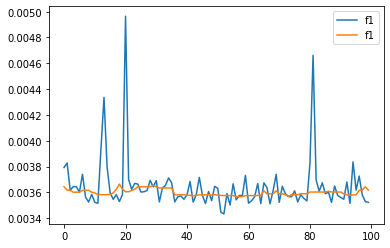

In [19]:
plt.plot(range(100),lf1,label='f1')
plt.plot(range(100),filtro_mediana(lf1,13),label='f1')
plt.legend()

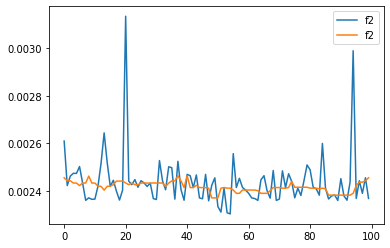

In [20]:
plt.plot(range(100),lf2,label='f2')
plt.plot(range(100),filtro_mediana(lf2,13),label='f2')
plt.legend()

In [21]:
from statistics import mean

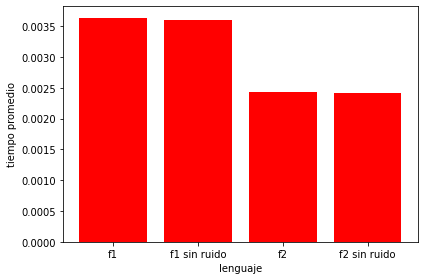

In [22]:
noms = ['f1','f1 sin ruido','f2','f2 sin ruido']
proms = [ 
    mean(lf1), 
    mean(filtro_mediana(lf1,7)),
    mean(lf2), 
    mean(filtro_mediana(lf2,7))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.tight_layout()

In [23]:
mean(filtro_mediana(lf1,21))/mean(filtro_mediana(lf2,21))

1.4873069183208079

En este caso, se observa que las operaciones de lectura escritura tienen más influencia en el tiempo de ejecución que el ruido.

## Como pasar un puntero a puntero en ctypes

In [24]:
%%file negmat.c
void negmat(double **A, double **B, int N)
{
    for(int i = 0; i < N; i++)
    {
        for(int j = 0; j < N; j++)
        {
            B[i][j] = 0.0 - A[i][j];
        }
    }
}

Writing negmat.c


In [25]:
# para generar el object file
! gcc -c -fpic negmat.c

# para crear la shared library
! gcc -shared  negmat.o -o negmat.so

In [26]:
def ctypes_negmat():
    # ruta de la shared library
    lib = ctypes.CDLL('./negmat.so')
    
    # tipo de dato de los argumentos
    lib.negmat.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.negmat

In [27]:
negmat = ctypes_negmat()

Los arreglos de numpy brindan información sobre la cantidad de bytes que hay entre elementos continuos y elementos de una fila y otra.

In [28]:
def ptr2ptr(x):
    return (x.__array_interface__['data'][0] + numpy.arange(x.shape[0])*x.strides[0]).astype(numpy.uintp)

In [29]:
n = 2048
A = numpy.random.rand(n,n)
B = 0-A

In [30]:
Bc = numpy.zeros_like(B)
App = ptr2ptr(A)
Bcpp = ptr2ptr(Bc)
negmat(App,Bcpp,n)
numpy.linalg.norm(B-Bc)/numpy.linalg.norm(B)

0.0

## Efectos de la localidad en la operación Matriz x Matrix

In [31]:
n = 512
A = numpy.random.rand(n,n)
B = numpy.random.rand(n,n)
C = numpy.dot(A,B)
App = ptr2ptr(A)
Bpp = ptr2ptr(B)

### Caso IJK

In [32]:
%%file mmIJK.c
void mmIJK(double **A, double **B, double **C, int N)
{
    for(int i = 0; i < N; i++)
    {
        for(int j = 0; j < N; j++)
        {
            for(int k = 0; k < N; k++)
            {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

Writing mmIJK.c


In [33]:
# para generar el object file
! gcc -c -fpic mmIJK.c

# para crear la shared library
! gcc -shared  mmIJK.o -o mmIJK.so

In [34]:
def ctypes_mmIJK():
    # ruta de la shared library
    lib = ctypes.CDLL('./mmIJK.so')
    
    # tipo de dato de los argumentos
    lib.mmIJK.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.mmIJK

In [35]:
mmIJK = ctypes_mmIJK()

In [36]:
Cijk = numpy.zeros_like(C)

In [37]:
Cijkpp = ptr2ptr(Cijk)

In [38]:
mmIJK(App,Bpp,Cijkpp,n)
numpy.linalg.norm(C-Cijk)/numpy.linalg.norm(C)

6.038164363504874e-16

### Caso IKJ

In [39]:
%%file mmIKJ.c
void mmIKJ(double **A, double **B, double **C, int N)
{
    for(int i = 0; i < N; i++)
    {
        for(int k = 0; k < N; k++)
        {
            for(int j = 0; j < N; j++)
            {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

Writing mmIKJ.c


In [40]:
# para generar el object file
! gcc -c -fpic mmIKJ.c

# para crear la shared library
! gcc -shared  mmIKJ.o -o mmIKJ.so

In [41]:
def ctypes_mmIKJ():
    # ruta de la shared library
    lib = ctypes.CDLL('./mmIKJ.so')
    
    # tipo de dato de los argumentos
    lib.mmIKJ.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.mmIKJ

In [42]:
mmIKJ = ctypes_mmIKJ()

In [43]:
Cikj = numpy.zeros_like(C)
Cikjpp = ptr2ptr(Cikj)

In [44]:
mmIKJ(App,Bpp,Cikjpp,n)
numpy.linalg.norm(C-Cikj)/numpy.linalg.norm(C)

6.038164363504874e-16

### Caso JKI

In [45]:
%%file mmJKI.c
void mmJKI(double **A, double **B, double **C, int N)
{
    for(int j = 0; j < N; j++)
    {
        for(int k = 0; k < N; k++)
        {
            for(int i = 0; i < N; i++)
            {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

Writing mmJKI.c


In [46]:
# para generar el object file
! gcc -c -fpic mmJKI.c

# para crear la shared library
! gcc -shared  mmJKI.o -o mmJKI.so

In [47]:
def ctypes_mmJKI():
    # ruta de la shared library
    lib = ctypes.CDLL('./mmJKI.so')
    
    # tipo de dato de los argumentos
    lib.mmJKI.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.mmJKI

In [48]:
mmJKI = ctypes_mmJKI()

In [49]:
Cjki = numpy.zeros_like(C)
Cjkipp = ptr2ptr(Cjki)

In [50]:
mmJKI(App,Bpp,Cjkipp,n)
numpy.linalg.norm(C-Cjki)/numpy.linalg.norm(C)

6.038164363504874e-16

### Caso JIK

In [51]:
%%file mmJIK.c
void mmJIK(double **A, double **B, double **C, int N)
{
    for(int j = 0; j < N; j++)
    {
        for(int i = 0; i < N; i++)
        {
            for(int k = 0; k < N; k++)
            {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

Writing mmJIK.c


In [52]:
# para generar el object file
! gcc -c -fpic mmJIK.c

# para crear la shared library
! gcc -shared  mmJIK.o -o mmJIK.so

In [53]:
def ctypes_mmJIK():
    # ruta de la shared library
    lib = ctypes.CDLL('./mmJIK.so')
    
    # tipo de dato de los argumentos
    lib.mmJIK.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.mmJIK

In [54]:
mmJIK = ctypes_mmJIK()

In [55]:
Cjik = numpy.zeros_like(C)
Cjikpp = ptr2ptr(Cjik)

In [56]:
mmJIK(App,Bpp,Cjikpp,n)
numpy.linalg.norm(C-Cjik)/numpy.linalg.norm(C)

6.038164363504874e-16

## Mediciones de tiempo

In [57]:
ns = 2**numpy.arange(1,10)
veces = range(40)

In [58]:
lijk = []
likj = []
ljki = []
ljik = []
for n in ns:
    lijki = []
    likji = []
    ljkii = []
    ljiki = []
    for _ in veces:
        # entradas
        A = numpy.random.rand(n,n)
        B = numpy.random.rand(n,n)
        # referencia
        C = numpy.dot(A,B)
        # para la forma IJK
        Cijk = numpy.zeros_like(C)
        # para la forma IKJ
        Cikj = numpy.zeros_like(C)
        # para la forma JKI
        Cjki = numpy.zeros_like(C)
        # para la forma JIK
        Cjik = numpy.zeros_like(C)
        # ptr 2 ptr
        App = ptr2ptr(A)
        Bpp = ptr2ptr(B)
        Cijkpp = ptr2ptr(Cijk)
        Cikjpp = ptr2ptr(Cikj)
        Cjkipp = ptr2ptr(Cjki)
        Cjikpp = ptr2ptr(Cjik)
        # IJK
        tic = time.time()
        mmIJK(App,Bpp,Cijkpp,n)
        toc = time.time()
        lijki.append(toc-tic)
        # IKJ
        tic = time.time()
        mmIKJ(App,Bpp,Cikjpp,n)
        toc = time.time()
        likji.append(toc-tic)
        # JKI
        tic = time.time()
        mmJKI(App,Bpp,Cjkipp,n)
        toc = time.time()
        ljkii.append(toc-tic)
        # JIK
        tic = time.time()
        mmJIK(App,Bpp,Cjikpp,n)
        toc = time.time()
        ljiki.append(toc-tic)
    lijk.append(mean(filtro_mediana(lijki,11)))
    likj.append(mean(filtro_mediana(likji,11)))
    ljki.append(mean(filtro_mediana(ljkii,11)))
    ljik.append(mean(filtro_mediana(ljiki,11)))

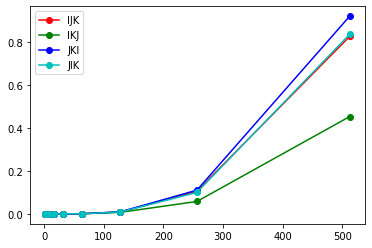

In [59]:
plt.plot(ns,lijk,'r-o',label='IJK')
plt.plot(ns,likj,'g-o',label='IKJ')
plt.plot(ns,ljki,'b-o',label='JKI')
plt.plot(ns,ljik,'c-o',label='JIK')
plt.legend()
plt.show()

Acercamiento a los dos últimos tamaños

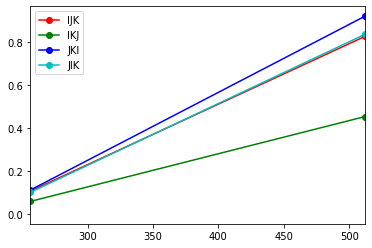

In [60]:
plt.plot(ns,lijk,'r-o',label='IJK')
plt.plot(ns,likj,'g-o',label='IKJ')
plt.plot(ns,ljki,'b-o',label='JKI')
plt.plot(ns,ljik,'c-o',label='JIK')
plt.xlim([ns[-2],ns[-1]])
plt.legend()
plt.show()

Una explicación detallada sobre el producto matriz-matriz se puede encontrar en el primer capítulo del libro "Matrix Computations" de Golub.

In [61]:
! rm *.o
! rm *.so
! rm *.c